# Build and Evaluate a Classification Model

In this notebook we will build classification models using the decision trees and logistic regression algorithms and choose the best one.


## Import the libraries we need


In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot

# Sklearn functionality
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score

# Convenience functions.  This can be found on the course github
from functions import *

# Define the task
"Make predictions about a country's life expectancy (L/M/H bands) from a set of metrics for the country."

# Acquire clean data
## Load the data
We will load our data.

In [2]:
# Load the data set
dataset = pd.read_csv("world_data.csv")

## Inspect the data

Identify the number of features (columns) and samples (rows)

In [3]:
# Examine the date shape
dataset.shape

(194, 17)

Take a quick look at the data to understand what you are dealing with.

In [4]:
# Inspect first few rows
dataset.head()

,country,happiness,income,lifeexp,sanitation,water,urbanpopulation,unemployment,literacy,inequality,murder,energy,childmortality,fertility,hiv,foodsupply,population
0,Afghanistan,3.982855,1750.0,57.9,39.2,63.0,11.0,NaN,39.0,NaN,NaN,NaN,73.2,4.80,5800.0,2090.0,33700000
1,Albania,4.606651,11000.0,77.6,97.7,91.4,NaN,6.090,96.8,29.0,2.30,808.0,14.0,1.71,NaN,3190.0,2920000
2,Argentina,6.697131,19100.0,76.5,94.8,99.6,43.1,0.856,97.9,41.4,4.65,2020.0,11.6,2.31,95000.0,3230.0,43400000
3,Armenia,4.348320,8180.0,75.4,91.6,98.9,36.7,7.110,99.6,32.4,1.12,1020.0,14.0,1.66,3600.0,2930.0,2920000
4,Australia,7.309061,43800.0,82.6,100.0,100.0,60.2,1.240,NaN,34.7,1.11,5480.0,3.8,1.86,22000.0,3280.0,23800000


Check we have sensible data types for each feature.  E.g. we don't want any numeric features to be showing as object type.

In [5]:
# Check data types
dataset.dtypes

country             object
happiness          float64
income             float64
lifeexp            float64
sanitation         float64
water              float64
urbanpopulation    float64
unemployment       float64
literacy           float64
inequality         float64
murder             float64
energy             float64
childmortality     float64
fertility          float64
hiv                float64
foodsupply         float64
population           int64
dtype: object

Check if there are nulls

In [6]:
# Check for nulls
dataset.isnull().mean().sort_values()

country            0.000000
water              0.000000
sanitation         0.000000
population         0.000000
income             0.005155
childmortality     0.005155
lifeexp            0.036082
fertility          0.051546
energy             0.128866
foodsupply         0.134021
inequality         0.175258
hiv                0.231959
literacy           0.231959
happiness          0.278351
urbanpopulation    0.386598
unemployment       0.422680
murder             0.520619
dtype: float64

## Clean data
Some of these features (murder, urbanpopulation, unemployment) are very sparsely populated.  If we were to impute the nulls, we would be estimating a large number of values.  I am going to discard them for now.  I may come back to these again later (remember, this is an iterative process).

In [7]:
# Discard very sparse features
dataset = dataset.drop(["murder","urbanpopulation","unemployment"], axis=1)

For the others I will just impute with the mean value of the feature.  Again, I may want to come back to this later.

In [8]:
# Compute the mean for each feature
means = dataset.mean().to_dict()

# Impute each null with the mean of that feature
for m in means:
    dataset[m] = dataset[m].fillna(value=means[m])

Have a think about our cleanup strategy here.  Could you take a more sophisticated approach?

Confirm we have no nulls now:

In [9]:
# Check for nulls
dataset.isnull().mean()

country           0.0
happiness         0.0
income            0.0
lifeexp           0.0
sanitation        0.0
water             0.0
literacy          0.0
inequality        0.0
energy            0.0
childmortality    0.0
fertility         0.0
hiv               0.0
foodsupply        0.0
population        0.0
dtype: float64

## Understand the data

### Compute descriptive stats
Descriptive stats give an idea of the range and spread of values for each feature and allows us to spot and unexpected patterns. 

In [10]:
# Compute descriptive stats
dataset.describe()

,happiness,income,lifeexp,sanitation,water,literacy,inequality,energy,childmortality,fertility,hiv,foodsupply,population
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,1.940000e+02,194.000000,1.940000e+02
mean,5.395765,17432.849741,71.933690,73.838247,86.329381,81.573826,38.579375,2183.725325,31.441451,2.835924,2.179917e+05,2845.952381,3.787195e+07
std,0.953547,19072.580021,7.466359,29.269367,17.568245,17.055722,7.257464,2618.536430,31.237992,1.336162,5.521169e+05,413.199619,1.419670e+08
min,2.701591,623.000000,49.600000,7.080000,19.300000,25.300000,16.600000,9.580000,2.200000,1.240000,6.000000e+01,1880.000000,1.100000e+04
25%,4.891838,3297.500000,66.425000,49.225000,77.900000,75.575000,34.000000,614.500000,8.200000,1.790000,1.025000e+04,2570.000000,1.982500e+06
50%,5.395765,11050.000000,72.550000,87.900000,94.950000,81.573826,38.579375,1565.000000,17.900000,2.415000,7.000000e+04,2845.952381,8.435000e+06
75%,5.880369,24100.000000,77.400000,97.700000,99.300000,95.375000,42.175000,2425.000000,49.225000,3.687500,2.179917e+05,3140.000000,2.742500e+07
max,7.603434,120000.000000,83.800000,100.000000,100.000000,100.000000,63.000000,18600.000000,137.000000,7.290000,5.600000e+06,3770.000000,1.400000e+09


### Visualise
A correlation matrix can be used to spot correlations between the features.  

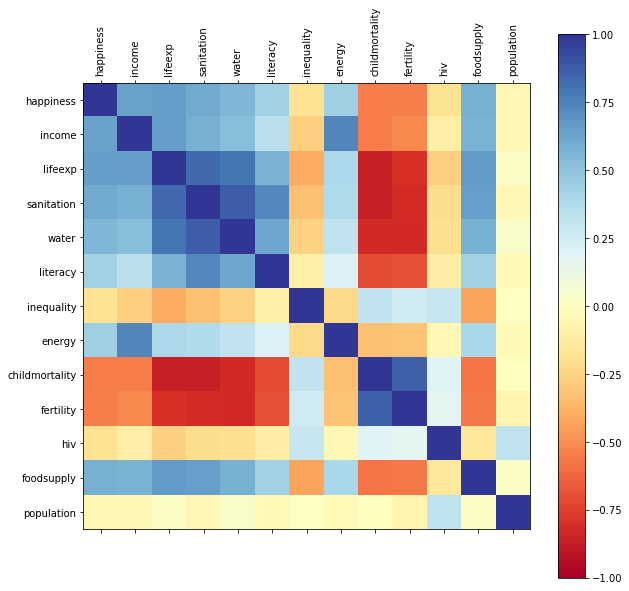

In [11]:
# Display a correlation matrix
correlationMatrix(dataset)

We can also plot some boxplots to understand the distribution of each feature.  

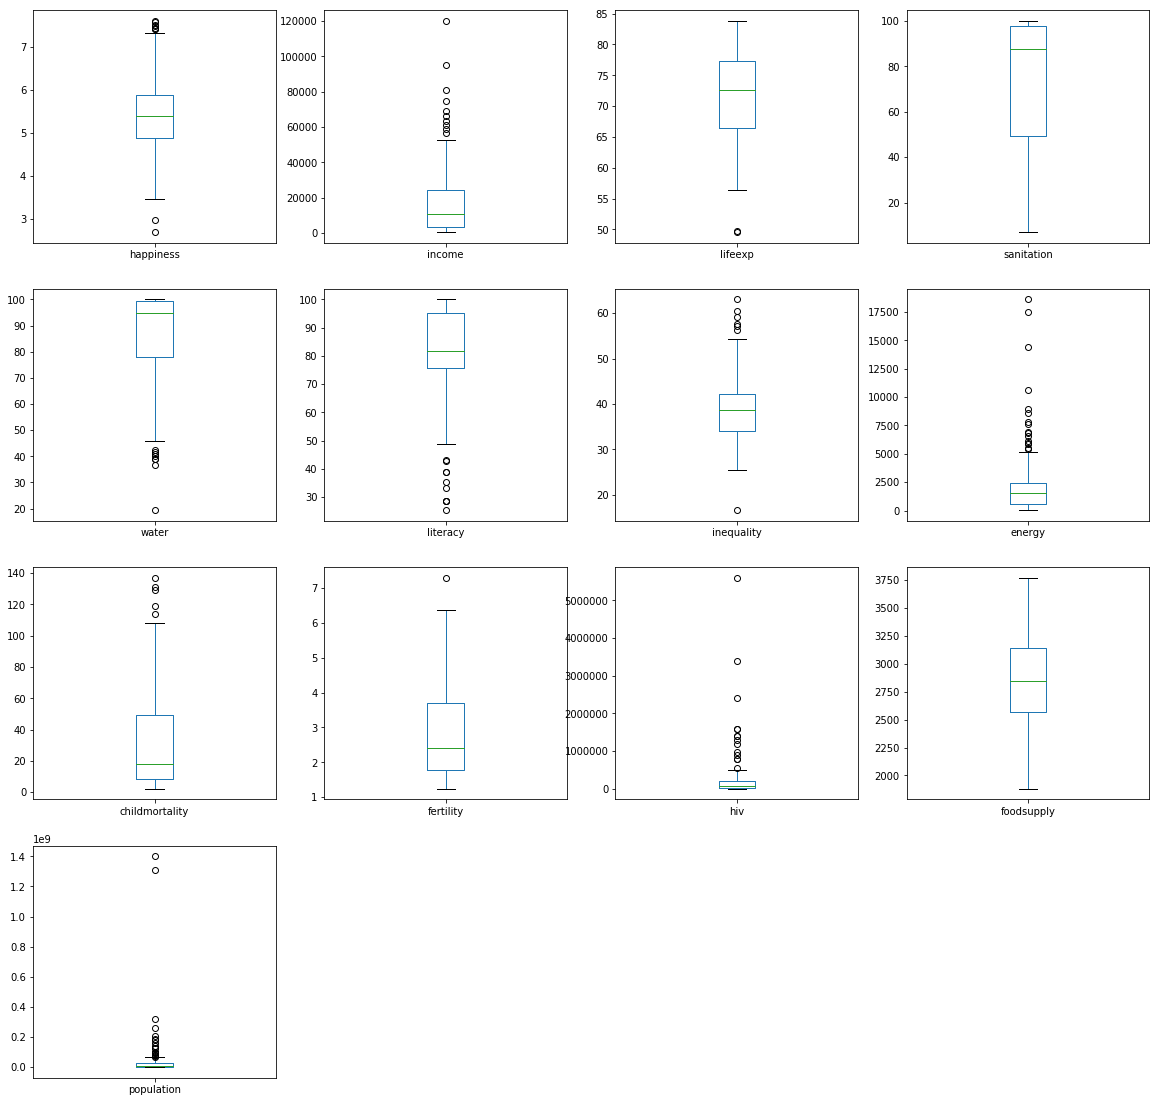

In [12]:
# Display boxplots for each numeric feature
boxPlotAll(dataset)

## Prepare Data
### Feature Engineering

We need to create our banded lifeexp feature, which will be the target feature:

In [13]:
# Bin lifexp into L, M and H bands
dataset = appendEqualCountsClass(dataset, "lifeexp_band", "lifeexp", 3, ["L","M","H"])

Check we have an even distribution of rows across the bands:

In [14]:
# Check how many rows in each bin
dataset.lifeexp_band.value_counts()

H    65
L    65
M    64
Name: lifeexp_band, dtype: int64

And let's check a few rows to confirm it has done as expected:

In [15]:
# Check the binning has worked as expected
dataset[['lifeexp','lifeexp_band']].head()

,lifeexp,lifeexp_band
0,57.9,L
1,77.6,H
2,76.5,H
3,75.4,M
4,82.6,H



### Select features and split into input and target features
Now we need to decide which columns to use as inputs and which is our target.  Let's remind ourselves of the columns we have:

In [16]:
dataset.columns

Index(['country', 'happiness', 'income', 'lifeexp', 'sanitation', 'water',
       'literacy', 'inequality', 'energy', 'childmortality', 'fertility',
       'hiv', 'foodsupply', 'population', 'lifeexp_band'],
      dtype='object')

And let's select lifeexp_band as our target feature (the one we will predict) and everything else as the input features (the ones we will use to make the prediction).

In [17]:
# Split into input and target features
y = dataset["lifeexp_band"]
X = dataset[['happiness', 'income', 'sanitation', 'water', 'literacy', 'inequality', 'energy', 'childmortality', 'fertility',  'hiv', 'foodsupply', 'population']]

In [18]:
X.head()

,happiness,income,sanitation,water,literacy,inequality,energy,childmortality,fertility,hiv,foodsupply,population
0,3.982855,1750.0,39.2,63.0,39.000000,38.579375,2183.725325,73.2,4.80,5800.000000,2090.0,33700000
1,4.606651,11000.0,97.7,91.4,96.800000,29.000000,808.000000,14.0,1.71,217991.677852,3190.0,2920000
2,6.697131,19100.0,94.8,99.6,97.900000,41.400000,2020.000000,11.6,2.31,95000.000000,3230.0,43400000
3,4.348320,8180.0,91.6,98.9,99.600000,32.400000,1020.000000,14.0,1.66,3600.000000,2930.0,2920000
4,7.309061,43800.0,100.0,100.0,81.573826,34.700000,5480.000000,3.8,1.86,22000.000000,3280.0,23800000


In [19]:
y.head()

0    L
1    H
2    H
3    M
4    H
Name: lifeexp_band, dtype: category
Categories (3, object): [L < M < H]

###  Scale features
When we ran dataset.describe() above we saw that the range of values between the min and max was different for different features.  

In [20]:
X.describe()

,happiness,income,sanitation,water,literacy,inequality,energy,childmortality,fertility,hiv,foodsupply,population
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,1.940000e+02,194.000000,1.940000e+02
mean,5.395765,17432.849741,73.838247,86.329381,81.573826,38.579375,2183.725325,31.441451,2.835924,2.179917e+05,2845.952381,3.787195e+07
std,0.953547,19072.580021,29.269367,17.568245,17.055722,7.257464,2618.536430,31.237992,1.336162,5.521169e+05,413.199619,1.419670e+08
min,2.701591,623.000000,7.080000,19.300000,25.300000,16.600000,9.580000,2.200000,1.240000,6.000000e+01,1880.000000,1.100000e+04
25%,4.891838,3297.500000,49.225000,77.900000,75.575000,34.000000,614.500000,8.200000,1.790000,1.025000e+04,2570.000000,1.982500e+06
50%,5.395765,11050.000000,87.900000,94.950000,81.573826,38.579375,1565.000000,17.900000,2.415000,7.000000e+04,2845.952381,8.435000e+06
75%,5.880369,24100.000000,97.700000,99.300000,95.375000,42.175000,2425.000000,49.225000,3.687500,2.179917e+05,3140.000000,2.742500e+07
max,7.603434,120000.000000,100.000000,100.000000,100.000000,63.000000,18600.000000,137.000000,7.290000,5.600000e+06,3770.000000,1.400000e+09


Many algorithms will not perform at their best when presented with such data, so we will scale the data to all be in the range 0 to 1:

In [21]:
# Rescale the data
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX = scaler.fit_transform(X)

# Convert X back to a Pandas DataFrame, for convenience
X = pd.DataFrame(rescaledX, columns=X.columns)

C:\Users\llewe\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


We can now see every feature now has a min of 0 and a max of 1:

In [22]:
X.describe()

,happiness,income,sanitation,water,literacy,inequality,energy,childmortality,fertility,hiv,foodsupply,population
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,0.549625,0.140813,0.718449,0.830600,0.753331,0.473693,0.116950,0.216925,0.263789,0.038917,0.511086,0.027044
std,0.194528,0.159768,0.314995,0.217698,0.228323,0.156411,0.140854,0.231736,0.220853,0.098593,0.218624,0.101406
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.446821,0.022404,0.453562,0.726146,0.673025,0.375000,0.032539,0.044510,0.090909,0.001820,0.365079,0.001408
50%,0.549625,0.087345,0.869780,0.937423,0.753331,0.473693,0.083668,0.116469,0.194215,0.012489,0.511086,0.006017
75%,0.648486,0.196663,0.975248,0.991326,0.938086,0.551185,0.129928,0.348850,0.404545,0.038917,0.666667,0.019582
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Build Models
BUild both decision trees and logistic regression models and see which one performs the best.


### Split into test and training sets
Split the X and y sets into training and test sets.

In [23]:
# Split into test and training sets
test_size = 0.33
seed = 1
X_train, X_test, Y_train, Y_test =  train_test_split(X, y, test_size=test_size, random_state=seed)

### Create multiple models and fit them
Let's build both models and fit with the training data.

In [24]:
# Build a decision tree model
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [25]:
# Build a logistic regression model
model_lr = LogisticRegression(solver='lbfgs', multi_class='auto')
model_lr.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### Check the models
Run the training data through both models and see how it performs.

In [26]:
# Check the model performance with the training data
predictions_dt = model_dt.predict(X_train)
print("DecisionTreeClassifier", accuracy_score(Y_train, predictions_dt))

DecisionTreeClassifier 1.0


In [27]:
# Check the model performance with the training data
predictions_lr = model_lr.predict(X_train)
print("LogisticRegression", accuracy_score(Y_train, predictions_lr))

LogisticRegression 0.8217054263565892


## Evaluate the models
Now we evaluate the models by testing with the test set:

In [28]:
predictions_dt = model_dt.predict(X_test)
print("DecisionTreeClassifier", accuracy_score(Y_test, predictions_dt))

DecisionTreeClassifier 0.6461538461538462


In [29]:
predictions_lr = model_lr.predict(X_test)
print("LogisticRegression", accuracy_score(Y_test, predictions_lr))

LogisticRegression 0.7230769230769231


### Choose the best performing model
Logistic Regression model will be our chosen model as it performed the best.

In [30]:
model = model_lr

## Iterate!
At this point, you should review your code and process and see what improvements could be made.

## Inspect the models
Here is the decision tree created for this exericise:

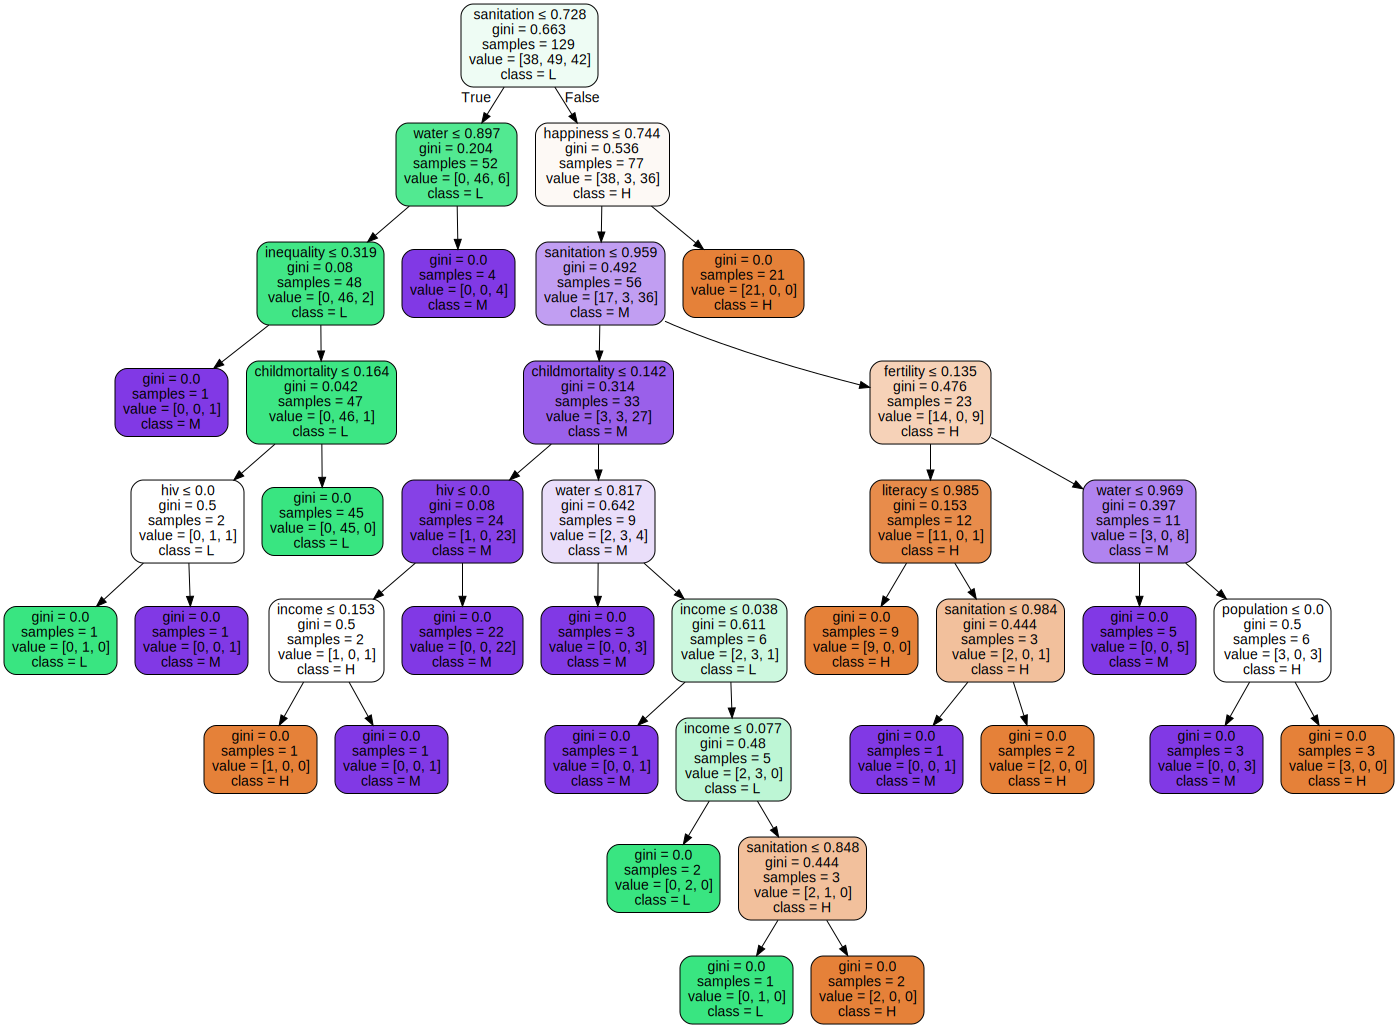

In [31]:
viewDecisionTree(model_dt, X.columns)

We can also display the feature importance.

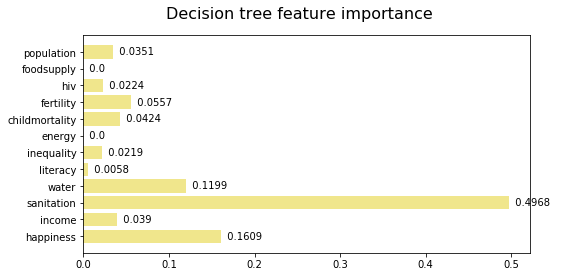

In [32]:
decisionTreeSummary(model_dt, X.columns)

For logistic regression we can examine the coefficients.  

In [33]:
model_lr.classes_

array(['H', 'L', 'M'], dtype=object)

In [34]:
model_lr.coef_

array([[ 1.56109512,  1.43854829,  1.21032309,  0.71015589,  0.16496136,
        -0.21151471,  0.38168319, -0.90984066, -0.7007721 , -0.06693589,
         1.35850726, -0.26528544],
       [-1.04391607, -0.40989364, -1.85609818, -1.39903662, -0.71497946,
         0.2072231 , -0.15851575,  1.53414928,  1.15354453,  0.24971128,
        -0.74221789,  0.09642796],
       [-0.51717906, -1.02865465,  0.64577509,  0.68888074,  0.5500181 ,
         0.00429161, -0.22316744, -0.62430862, -0.45277243, -0.18277539,
        -0.61628937,  0.16885748]])

And we can plot them:

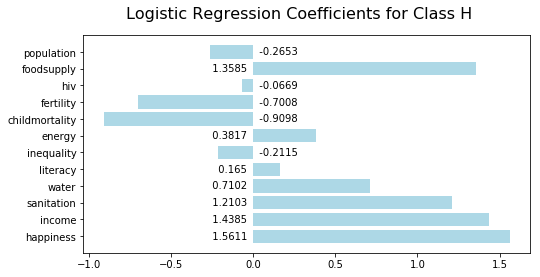

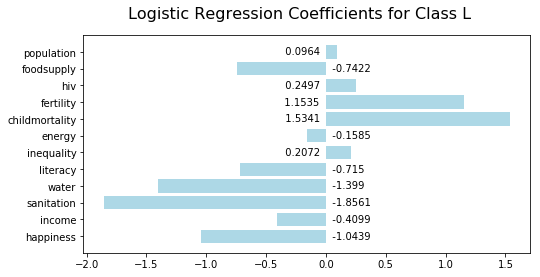

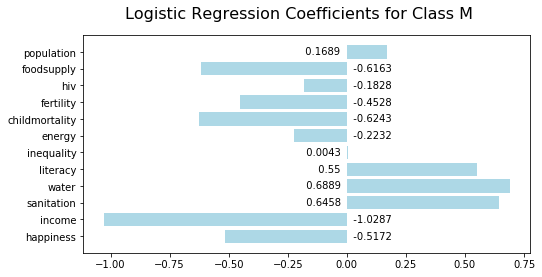

In [35]:
logisticRegressionSummary(model_lr, X.columns)